<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Start" data-toc-modified-id="Start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Start</a></span></li><li><span><a href="#model_dict-define" data-toc-modified-id="model_dict-define-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>model_dict define</a></span></li><li><span><a href="#batch-infer" data-toc-modified-id="batch-infer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>batch infer</a></span></li><li><span><a href="#test-outputs" data-toc-modified-id="test-outputs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>test outputs</a></span></li><li><span><a href="#Definiation-of-the-pred-results" data-toc-modified-id="Definiation-of-the-pred-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Definiation of the pred results</a></span></li><li><span><a href="#Single-functions-for-different-metrics" data-toc-modified-id="Single-functions-for-different-metrics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Single functions for different metrics</a></span></li><li><span><a href="#function:metric_report" data-toc-modified-id="function:metric_report-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>function:metric_report</a></span></li><li><span><a href="#start-ensemble-bathc-processing" data-toc-modified-id="start-ensemble-bathc-processing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>start ensemble bathc processing</a></span></li><li><span><a href="#results-output" data-toc-modified-id="results-output-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>results output</a></span></li></ul></div>

## Start

In [8]:
import torch

from torch import nn
from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from PIL import Image

import os

import timm
from data_generator_test import *
from tools import *
%config Completer.use_jedi = False

In [9]:
timm.list_models('*', pretrained=True)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficie

In [10]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
# torch.cuda.set_device(2)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# num_classes = 1
#model = Globalocal(depth=34, num_classes=num_classes, with_lateral = [0,0,1,1], Net_type = 'with_global_detail').cuda()
# model = Globalocal(depth=34, num_classes=num_classes, with_lateral = False , Net_type = 'with_global').cuda()
# model = nn.DataParallel(model)



## model_dict define

In [11]:
model_base_dict={
    'vit_base_patch16_224':r'E:\Xing\Covid_19_xray\train_log\Apr15_timm_vit_augmented\Fri16Apr2021-172737\save',
    'tf_efficientnet_b5':r'E:\Xing\Covid_19_xray\train_log\Apr16_timm_effnetb5_augmented\Sat17Apr2021-164238\save',
    'efficientnet_b3':r'E:\Xing\Covid_19_xray\train_log\Apr16_timm_effnet_augmented\Sat17Apr2021-064925\save',
    'resnet34':r'E:\Xing\Covid_19_xray\train_log\Apr19_timm_resnet34_augmented\Mon19Apr2021-184738\save',
    'vit_deit_base_patch16_224':r'E:\Xing\Covid_19_xray\train_log\Apr22_timm_vit_pch16_deit_augmented\Fri23Apr2021-002539\save',
    'swin_base_patch4_window7_224':r'E:\Xing\Covid_19_xray\train_log\Apr24_timm_vit_swin_224_augmented\Sun25Apr2021-055916\save'
}

In [12]:
model_dict = {}
for key in model_base_dict.keys():
    model_dict[key] = {}
    model_dict[key]['model_path']=model_base_dict[key]

In [13]:
# Creating a Transformation Object
img_size = 224
valid_bs = 1
test_transform = torchvision.transforms.Compose([
    # Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(img_size, img_size)),
    # We don't do data augmentation in the test/val set
    torchvision.transforms.ToTensor(),  # Converting to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Normalizing the data to the data that the ResNet18 was trained on

])

In [14]:
valconfig = {"dataset": "mura","subset": '1'}
val_config = dataconfig(**valconfig)
validation_data = DataGenerator(val_config,transform= test_transform)
val_loader = DataLoader(validation_data, num_workers=4,batch_size=valid_bs, drop_last=True)

In [15]:
import cv2
from tools import *

## batch infer

In [16]:
def model_eval(model,data_loader):
    losses_val = AverageMeter()
    accuracies_val = AverageMeter()
    sfm = nn.Softmax()
    model.eval()
    file_name = []
    y = []
    pred = []

    #fileio.maybe_make_new_dir(result_path)
    with torch.no_grad():
        for j, (images_val, targets_val,image_name) in tqdm(enumerate(data_loader)):
            targets_val = targets_val.float().cuda()
            outputs_val = model(images_val.cuda())
            outputs_val = sfm(outputs_val)
            loss_val = criterion(outputs_val, targets_val.long())

            acc_val = calculate_accuracy(outputs_val, targets_val)
            losses_val.update(loss_val.item(), targets_val.size(0))
            accuracies_val.update(acc_val, targets_val.size(0))
            y.append(targets_val.cpu().numpy())
    #         pred.append(torch.max(outputs_val,1))
            pred.append(outputs_val[:,1].cpu().numpy())
            file_name.append(image_name)
    
    y= np.asarray(y).squeeze()
    pred= np.asarray(pred).squeeze()

    print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)
    
    return y,pred,file_name

In [17]:
model_name = r'\best_model.pth'
criterion = nn.CrossEntropyLoss()
for key in model_dict.keys():
    print(key,'*'*10)
    model = timm.create_model(key, pretrained=True, num_classes=2)
    checkpoint = torch.load(model_dict[key]['model_path'] + model_name)
    model.load_state_dict(checkpoint['state_dict'])
    model.cuda()

    y,pred,filename = model_eval(model,val_loader)
    print(pred)
    model_dict[key]['y']=y
    model_dict[key]['pred']=pred
    model_dict[key]['filename']=filename
    

vit_base_patch16_224 **********
len = 74


0it [00:00, ?it/s]

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


val_loss:  0.66545226525616 val_acc:  0.6486486486486487
[0.99996865 0.99996865 0.9999684  0.9998982  0.99998105 0.9998017
 0.999954   0.9995407  0.99996924 0.99998295 0.99998295 0.9999814
 0.9999572  0.9997224  0.9999801  0.99982244 0.99982244 0.9999815
 0.99994254 0.9999746  0.9995301  0.9995301  0.999972   0.9999006
 0.9999006  0.9999819  0.999974   0.87851745 0.99996173 0.99996173
 0.999987   0.9999832  0.9999802  0.9995782  0.99998665 0.99997103
 0.99997103 0.99997103 0.9999614  0.9999614  0.99469155 0.00166097
 0.99995327 0.9999745  0.99988973 0.99992096 0.9998952  0.99998677
 0.9999813  0.9999651  0.9999651  0.9999876  0.99996185 0.9997608
 0.9997696  0.9997793  0.9999671  0.999943   0.99996495 0.99996865
 0.99991894 0.99998057 0.99980456 0.99998045 0.9999865  0.9999865
 0.9999838  0.99997044 0.9995239  0.99922895 0.9877351  0.9877351
 0.99996567 0.99261826]
tf_efficientnet_b5 **********
len = 74


0it [00:00, ?it/s]

val_loss:  0.6570526582969202 val_acc:  0.6486486486486487
[1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 9.9999928e-01
 9.9996924e-01 1.0000000e+00 9.9999917e-01 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 9.9999988e-01 7.6208901e-01 9.9957985e-01
 9.9999928e-01 9.9999928e-01 1.0000000e+00 9.9965703e-01 1.0000000e+00
 9.9981636e-01 9.9981636e-01 1.0000000e+00 9.9999642e-01 9.9999642e-01
 1.0000000e+00 1.0000000e+00 9.9992418e-01 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 9.9983346e-01 9.9999976e-01 1.0000000e+00
 9.9974185e-01 9.9974185e-01 9.9974185e-01 9.9999654e-01 9.9999654e-01
 1.0113584e-02 1.7849755e-01 1.0000000e+00 9.9991703e-01 1.0000000e+00
 9.9999344e-01 9.9985123e-01 1.0000000e+00 9.9999940e-01 9.9982291e-01
 9.9982291e-01 9.9999928e-01 9.9999988e-01 1.0000000e+00 9.9999952e-01
 9.9982965e-01 1.0000000e+00 9.9999309e-01 1.0000000e+00 1.0000000e+00
 9.9999309e-01 1.0000000e+00 2.2458781e-02 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0

0it [00:00, ?it/s]

val_loss:  0.6821299493312836 val_acc:  0.6351351351351351
[9.9999964e-01 9.9999964e-01 1.0000000e+00 1.0000000e+00 9.9999988e-01
 9.9998724e-01 9.9999821e-01 9.9999976e-01 9.9999714e-01 9.6923256e-01
 9.6923256e-01 1.0000000e+00 9.5036840e-01 9.9973994e-01 2.8560564e-02
 8.7609583e-01 8.7609583e-01 9.9263257e-01 9.9480313e-01 9.9960369e-01
 5.5040565e-04 5.5040565e-04 1.0000000e+00 9.9999988e-01 9.9999988e-01
 9.9999940e-01 9.9956018e-01 9.9344569e-01 1.0000000e+00 1.0000000e+00
 9.9999523e-01 1.0000000e+00 8.4655428e-01 3.4856120e-01 1.0000000e+00
 5.4751069e-04 5.4751069e-04 5.4751069e-04 2.4303231e-02 2.4303231e-02
 9.1441327e-01 3.0991479e-05 1.0000000e+00 6.4662709e-03 4.3911286e-02
 9.8956293e-01 9.9549133e-01 1.0000000e+00 9.9982625e-01 9.5636159e-01
 9.5636159e-01 9.9999988e-01 9.8925322e-01 9.9999797e-01 1.0000000e+00
 9.9997163e-01 1.0000000e+00 9.2716593e-01 9.9997139e-01 9.9999917e-01
 9.9929202e-01 9.9993682e-01 9.9999809e-01 9.9998522e-01 1.0000000e+00
 9.9999976e-01 1.0

0it [00:00, ?it/s]

val_loss:  0.6627015684907501 val_acc:  0.6486486486486487
[0.99998784 0.99998784 0.9999994  0.99939585 0.99999607 0.99983466
 0.9996809  0.99998474 0.99993503 0.99999917 0.99999917 0.99999607
 0.9998178  0.9858116  0.99758804 0.96574455 0.96574455 0.9999999
 0.9998456  0.9999188  0.89638484 0.89638484 0.9999982  0.9999999
 0.9999999  0.99999714 0.9999932  0.29464182 0.9999999  0.9999999
 0.9999869  0.9999999  0.9997373  0.9949162  0.99999917 0.9970041
 0.9970041  0.9970041  0.9999856  0.9999856  0.0681888  0.00536362
 0.99994004 0.99999166 0.99515224 0.70900184 0.24827702 0.99999964
 0.99999046 0.9999937  0.9999937  0.99427634 0.99278814 0.9939349
 0.99999917 0.99866796 0.99993455 0.9809914  0.99999917 0.9999989
 0.99995685 0.99999356 0.48621726 0.99999404 0.98409605 0.9999982
 0.999997   0.9868824  0.999335   0.06449439 0.9998084  0.9998084
 0.99325    0.02879768]
vit_deit_base_patch16_224 **********
len = 74


0it [00:00, ?it/s]

val_loss:  0.6588574901625917 val_acc:  0.6486486486486487
[9.9999332e-01 9.9999332e-01 9.9999857e-01 9.9999857e-01 9.9999797e-01
 9.9999380e-01 9.9999750e-01 9.9999571e-01 9.9999726e-01 9.9999845e-01
 9.9999845e-01 9.9999952e-01 9.9999392e-01 9.9971372e-01 9.9993467e-01
 9.9999022e-01 9.9999022e-01 9.9999750e-01 9.7703767e-01 9.9999797e-01
 9.9998593e-01 9.9998593e-01 9.9999976e-01 9.9999642e-01 9.9999642e-01
 9.9999821e-01 9.9999905e-01 9.9792588e-01 9.9999964e-01 9.9999964e-01
 9.9999964e-01 9.9999976e-01 9.9956864e-01 9.9921799e-01 9.9999905e-01
 9.9968958e-01 9.9968958e-01 9.9968958e-01 9.9999309e-01 9.9999309e-01
 6.3872176e-01 4.2526430e-04 9.9999154e-01 9.9929357e-01 9.9999726e-01
 9.9986017e-01 9.9520469e-01 9.9999857e-01 9.9999964e-01 9.9993682e-01
 9.9993682e-01 9.9999666e-01 9.9998045e-01 9.9999774e-01 9.9998987e-01
 9.9409902e-01 9.9999917e-01 9.9998295e-01 9.9983430e-01 9.9999940e-01
 9.9999607e-01 9.9999893e-01 9.9999416e-01 9.9999928e-01 9.9999678e-01
 9.9999976e-01 9.9

0it [00:00, ?it/s]

val_loss:  0.6870195672318742 val_acc:  0.6216216216216216
[9.9918836e-01 9.9918836e-01 9.9853706e-01 9.9771190e-01 9.9862385e-01
 9.9521291e-01 9.9918193e-01 9.4672078e-01 9.9886912e-01 9.9702519e-01
 9.9702519e-01 9.9898809e-01 9.9874300e-01 9.9698466e-01 9.2546332e-01
 4.5183033e-02 4.5183033e-02 9.9830687e-01 9.0624332e-01 9.9764854e-01
 9.2557824e-01 9.2557824e-01 9.9933571e-01 9.9766028e-01 9.9766028e-01
 9.9920231e-01 9.9845338e-01 9.9627614e-01 9.9879873e-01 9.9879873e-01
 9.9922860e-01 9.9923158e-01 9.9854505e-01 1.8609021e-02 9.9935418e-01
 9.9687397e-01 9.9687397e-01 9.9687397e-01 9.9738735e-01 9.9738735e-01
 9.4962806e-01 1.6734414e-02 9.9673575e-01 9.9318695e-01 9.9653035e-01
 9.9684590e-01 8.3607334e-01 9.9884772e-01 9.9468577e-01 9.9831450e-01
 9.9831450e-01 9.9754828e-01 9.9889767e-01 9.9876523e-01 9.9766648e-01
 9.9321753e-01 9.9685103e-01 9.9340290e-01 9.9910969e-01 9.9909866e-01
 9.9868482e-01 9.9913114e-01 9.9885547e-01 9.9247640e-01 9.9959213e-01
 9.9951375e-01 9.9

In [33]:
def visulize_cam(model,df,image_num,criteration,num_class,title=''):
    plt.figure(figsize=(20,12))
    for i in range(image_num):
        ori_image = Image.open(df.loc[i,'filename'][0]).convert('RGB')
        image = test_transform(ori_image)
        print(image.shape)
        label = torch.tensor(df.loc[i,'y'])
        pred = df.loc[i,'pred']
        cam_feature = Visualizations.generate_grad_cam_inter(model, image.cuda(), label.cuda().long(), criteration, num_classes=2)
        image = image.cpu().numpy().transpose((1, 2, 0))
        cam_image = Visualizations.localize(cam_feature, image*255,frac=0.6)

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        cam_image = cam_image * std + mean
        cam_image = np.clip(cam_image, 0., 1.)
        plt.subplot(2,image_num,i+1),plt.imshow(cam_image)
        
        
        plt.xlabel(f'{label}')
        plt.ylabel(f'{pred}')
        
        plt.subplot(2,image_num,image_num+i+1),plt.imshow(ori_image)
        
        plt.xlabel(f'{label}')
        plt.ylabel(f'{pred}')
        
        plt.tight_layout(h_pad=0.5,w_pad=0.5)
    plt.suptitle(title)
        

vit_base_patch16_224 **********
tf_efficientnet_b5 **********
efficientnet_b3 **********
resnet34 **********
len = 74


0it [00:00, ?it/s]

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


val_loss:  0.6627015684907501 val_acc:  0.6486486486486487
[0.99998784 0.99998784 0.9999994  0.99939585 0.99999607 0.99983466
 0.9996809  0.99998474 0.99993503 0.99999917 0.99999917 0.99999607
 0.9998178  0.9858116  0.99758804 0.96574455 0.96574455 0.9999999
 0.9998456  0.9999188  0.89638484 0.89638484 0.9999982  0.9999999
 0.9999999  0.99999714 0.9999932  0.29464182 0.9999999  0.9999999
 0.9999869  0.9999999  0.9997373  0.9949162  0.99999917 0.9970041
 0.9970041  0.9970041  0.9999856  0.9999856  0.0681888  0.00536362
 0.99994004 0.99999166 0.99515224 0.70900184 0.24827702 0.99999964
 0.99999046 0.9999937  0.9999937  0.99427634 0.99278814 0.9939349
 0.99999917 0.99866796 0.99993455 0.9809914  0.99999917 0.9999989
 0.99995685 0.99999356 0.48621726 0.99999404 0.98409605 0.9999982
 0.999997   0.9868824  0.999335   0.06449439 0.9998084  0.9998084
 0.99325    0.02879768]
      y      pred                                           filename
0   0.0  0.999988  (E:\Xing\Covid_19_xray\data\test\

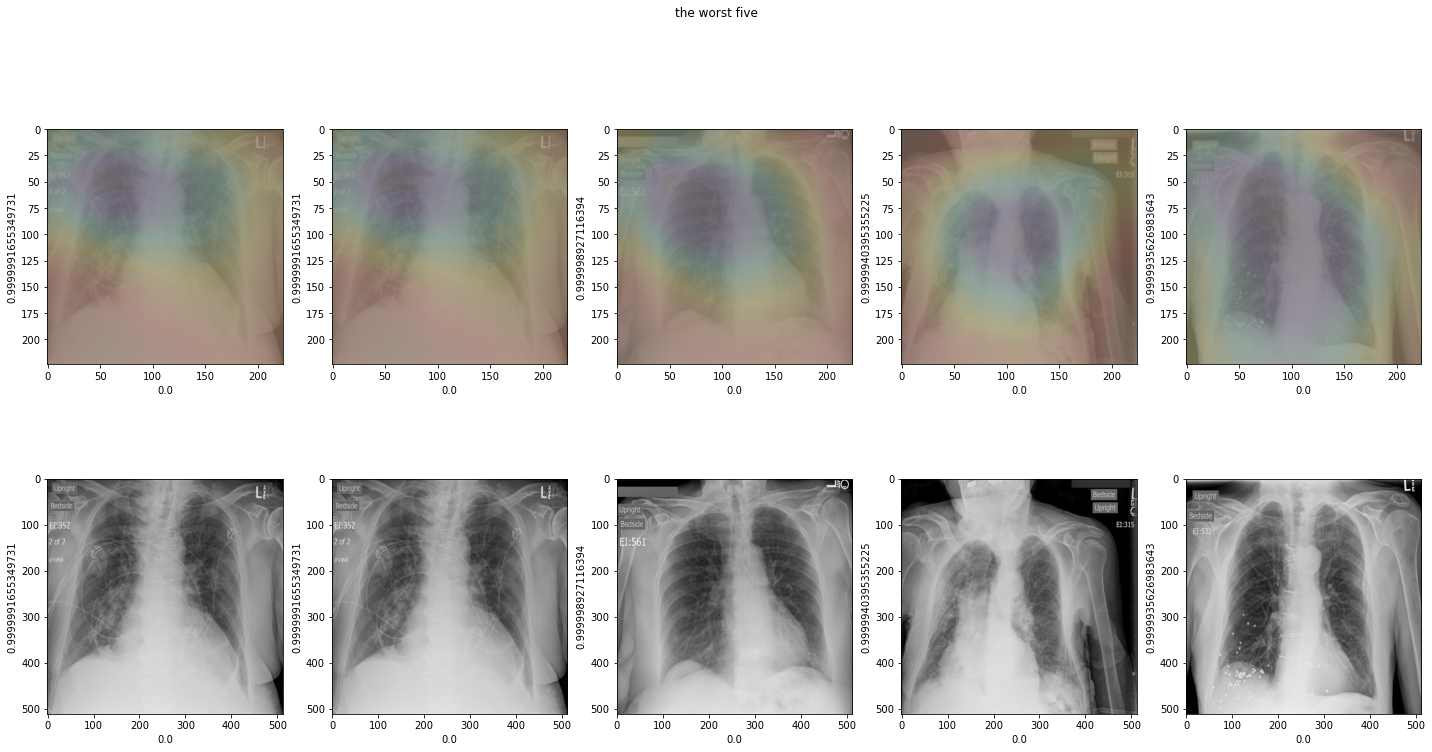

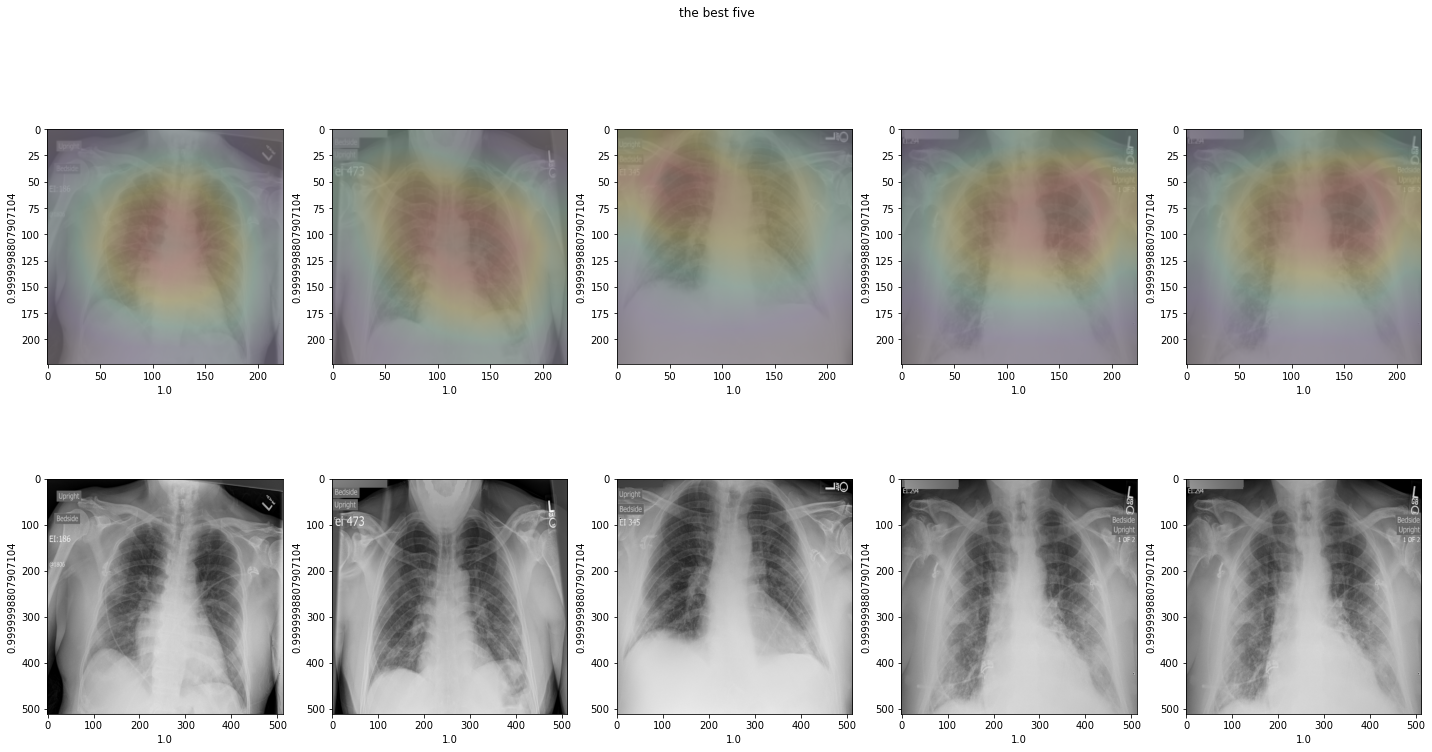

In [34]:
from Own_util.Visualizations import Visualizations
model_name = r'\best_model.pth'
criteration = nn.CrossEntropyLoss()
num_classes = 2
visual = Visualizations(class_names=list(np.arange(num_classes)),img_num=16)

for key in model_dict.keys():
    print(key,'*'*10)
    if 'resnet' not in key:
        continue
    model = timm.create_model(key, pretrained=True, num_classes=2)
    checkpoint = torch.load(model_dict[key]['model_path'] + model_name)
    model.load_state_dict(checkpoint['state_dict'])
    model.cuda()

    y,pred,filename = model_eval(model,val_loader)
#     print(y, pred,filename)
    print(pred)
    df = pd.DataFrame({
        'y':y,
        'pred':pred,
        'filename':filename
    })
    
    print(df)
    df['diff'] = df.apply(lambda x: abs(x['y']-x['pred']), axis=1)
    
    df.sort_values(by='diff',ascending=False, inplace=True)
    df.reset_index(inplace=True)
    
    print(df)
    
    visulize_cam(model,df,image_num=5,criteration=criteration,num_class=2,title = 'the worst five')
    
    print('+'*20)
    df.sort_values(by='diff',ascending=True, inplace=True)
    df.reset_index(inplace=True)
    
    print(df)
    
    visulize_cam(model,df,image_num=5,criteration=criteration,num_class=2,title = 'the best five')
    
    model_dict[key]['y']=y
    model_dict[key]['pred']=pred
    model_dict[key]['filename']=filename
    model_dict[key]['dataframe'] = df
    

## test outputs

In [17]:
test_df = pd.DataFrame.from_dict(model_dict,orient='columns')

In [18]:
test_df.head()

,vit_base_patch16_224,tf_efficientnet_b5,efficientnet_b3,resnet34,vit_deit_base_patch16_224,swin_base_patch4_window7_224
model_path,E:\Xing\Covid_19_xray\train_log\Apr15_timm_vit...,E:\Xing\Covid_19_xray\train_log\Apr16_timm_eff...,E:\Xing\Covid_19_xray\train_log\Apr16_timm_eff...,E:\Xing\Covid_19_xray\train_log\Apr19_timm_res...,E:\Xing\Covid_19_xray\train_log\Apr22_timm_vit...,E:\Xing\Covid_19_xray\train_log\Apr24_timm_vit...
y,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
pred,"[0.99973136, 0.9998752, 0.99472505, 0.99937457...","[1.0, 1.0, 0.99999905, 1.0, 0.9999826, 0.99993...","[0.9812773, 0.99998283, 0.99993634, 0.9999969,...","[0.9998418, 0.9400582, 0.10327593, 0.071540944...","[0.14926794, 0.9970693, 0.99945575, 0.5530565,...","[0.9984175, 0.9980773, 0.97944987, 0.98411036,..."
filename,[(E:\Xing\Covid_19_xray\data\test\deidcxr\pngd...,[(E:\Xing\Covid_19_xray\data\test\deidcxr\pngd...,[(E:\Xing\Covid_19_xray\data\test\deidcxr\pngd...,[(E:\Xing\Covid_19_xray\data\test\deidcxr\pngd...,[(E:\Xing\Covid_19_xray\data\test\deidcxr\pngd...,[(E:\Xing\Covid_19_xray\data\test\deidcxr\pngd...


In [11]:
# torch.cuda.set_device(3)
losses_val = AverageMeter()
accuracies_val = AverageMeter()
sfm = nn.Softmax()
model.eval()
y = []
pred = []

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for j, (images_val, targets_val) in tqdm(enumerate(val_loader)):
        targets_val = targets_val.float().cuda()
        outputs_val = model(images_val.cuda())
        outputs_val = sfm(outputs_val)
        loss_val = criterion(outputs_val, targets_val.long())
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
#         pred.append(torch.max(outputs_val,1))
        pred.append(outputs_val[:,1].cpu().numpy())

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)


KeyboardInterrupt: 

In [11]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [12]:
print(model_dict.keys())

dict_keys(['vit_base_patch16_224', 'tf_efficientnet_b5', 'efficientnet_b3', 'resnet34', 'vit_deit_base_patch16_224', 'swin_base_patch4_window7_224'])


## Definiation of the pred results

In [11]:
y = model_dict['vit_base_patch16_224']['y']
pred_vit_base = model_dict['vit_base_patch16_224']['pred']
pred_deit = model_dict['vit_deit_base_patch16_224']['pred']
pred_swin = model_dict['swin_base_patch4_window7_224']['pred']
pred_eff3b = model_dict['efficientnet_b3']['pred']
pred_eff5b = model_dict['tf_efficientnet_b5']['pred']
pred_res34 = model_dict['resnet34']['pred']

In [12]:
pred_list = [pred_vit_base,pred_deit,pred_swin,pred_eff3b,pred_eff5b,pred_res34]

In [13]:
pred = np.vstack((pred_vit_base,pred_eff5b,pred_eff3b,pred_swin))

In [14]:
pred_en = pred.mean(axis=0)

In [15]:
pred_en.shape

(74,)

In [23]:
pred_en = pred_vit_base

## Single functions for different metrics

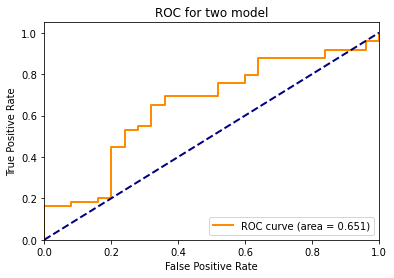

In [16]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, pred_en)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for two model')
plt.legend(loc="lower right")
plt.show()

In [99]:
from sklearn.metrics import confusion_matrix

threshold = 0.35

pred_t = pred_en > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

In [100]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.91, 0.9744525547445255)

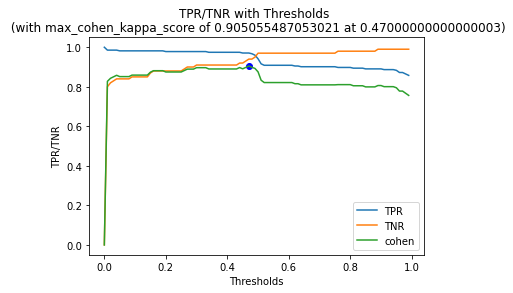

In [101]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred_en > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='cohen')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [91]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

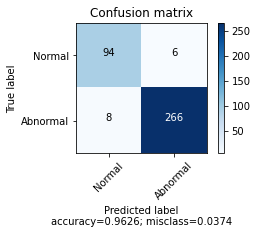

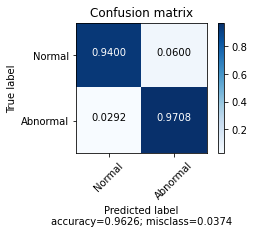

In [102]:
from sklearn.metrics import confusion_matrix

threshold = 0.47

pred_t = pred_en > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [103]:
target_names = ('Normal','Abnormal')
pred_t = pred_en > 0.47
df = metrics.classification_report(y,pred_t,target_names=target_names,digits=4)
print(df)

              precision    recall  f1-score   support

      Normal     0.9216    0.9400    0.9307       100
    Abnormal     0.9779    0.9708    0.9744       274

    accuracy                         0.9626       374
   macro avg     0.9498    0.9554    0.9525       374
weighted avg     0.9629    0.9626    0.9627       374



## function:metric_report

In [17]:
import numpy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score


def metric_report(y,pred,target_names=('Normal','Abnormal'),thresh = None, ret = True, prt = True):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred_en)
    roc_auc = metrics.auc(fpr, tpr)
    
    
    mali = []
    beni = []
    cohen = []
    tt = numpy.arange(0,1,0.01)
    for thres in tt:
        pred_t = pred > thres
        pred_t.astype(int)
        cm = confusion_matrix(y,pred_t)
        mali.append(cm[1,1]/sum(cm[1,:]))
        beni.append(cm[0,0]/sum(cm[0,:]))
        cohen.append(cohen_kappa_score(y,pred_t))
    net_max = cohen.index(max(cohen))
    cohen_index = max(cohen)
    bst_thresh = tt[net_max]
    
    
#     target_names = ('Normal','Abnormal')
    if thresh:
        f_thresh = thresh
    else:            
        f_thresh = bst_thresh
        
    pred_t = pred > f_thresh
    df = metrics.classification_report(y,pred_t,target_names=target_names,digits=3)
    
    if prt:
        print('Auc is {:0.3f}, Cohen_kappa is {:0.3f}, Thresh = {}'.format(roc_auc,cohen_index,f_thresh))  
        print(df)
    
    if ret:
        return roc_auc,cohen_index,f_thresh,df
        

In [18]:
metric_report(y,pred_en)

Auc is 0.651, Cohen_kappa is 0.315, Thresh = 0.74
              precision    recall  f1-score   support

      Normal      0.516     0.640     0.571        25
    Abnormal      0.791     0.694     0.739        49

    accuracy                          0.676        74
   macro avg      0.653     0.667     0.655        74
weighted avg      0.698     0.676     0.682        74



(0.6506122448979591,
 0.31534309946029304,
 0.74,
 '              precision    recall  f1-score   support\n\n      Normal      0.516     0.640     0.571        25\n    Abnormal      0.791     0.694     0.739        49\n\n    accuracy                          0.676        74\n   macro avg      0.653     0.667     0.655        74\nweighted avg      0.698     0.676     0.682        74\n')

## start ensemble bathc processing

In [19]:
import itertools

In [32]:
ensemble_ls_2 = itertools.combinations(pred_list,2)

In [33]:
for i,ls in enumerate(ensemble_ls_2):
    print(i)
    pred_en = np.array(ls).mean(axis = 0)
    metric_report(y,pred_en)

0
Auc is 0.470, Cohen_kappa is 0.047, Thresh = 0.2
              precision    recall  f1-score   support

      Normal      0.429     0.120     0.188        25
    Abnormal      0.672     0.918     0.776        49

    accuracy                          0.649        74
   macro avg      0.550     0.519     0.482        74
weighted avg      0.590     0.649     0.577        74

1
Auc is 0.584, Cohen_kappa is 0.184, Thresh = 0.97
              precision    recall  f1-score   support

      Normal      0.425     0.680     0.523        25
    Abnormal      0.765     0.531     0.627        49

    accuracy                          0.581        74
   macro avg      0.595     0.605     0.575        74
weighted avg      0.650     0.581     0.592        74

2
Auc is 0.580, Cohen_kappa is 0.264, Thresh = 0.65
              precision    recall  f1-score   support

      Normal      0.472     0.680     0.557        25
    Abnormal      0.789     0.612     0.690        49

    accuracy               

In [20]:
key_set = model_dict.keys()

In [21]:
np.arange(2,7)

array([2, 3, 4, 5, 6])

In [22]:
dict_ensm = itertools.combinations(model_dict.keys(),2)

In [23]:
for keys in dict_ensm:
    print(keys)

('vit_base_patch16_224', 'tf_efficientnet_b5')
('vit_base_patch16_224', 'efficientnet_b3')
('vit_base_patch16_224', 'resnet34')
('vit_base_patch16_224', 'vit_deit_base_patch16_224')
('vit_base_patch16_224', 'swin_base_patch4_window7_224')
('tf_efficientnet_b5', 'efficientnet_b3')
('tf_efficientnet_b5', 'resnet34')
('tf_efficientnet_b5', 'vit_deit_base_patch16_224')
('tf_efficientnet_b5', 'swin_base_patch4_window7_224')
('efficientnet_b3', 'resnet34')
('efficientnet_b3', 'vit_deit_base_patch16_224')
('efficientnet_b3', 'swin_base_patch4_window7_224')
('resnet34', 'vit_deit_base_patch16_224')
('resnet34', 'swin_base_patch4_window7_224')
('vit_deit_base_patch16_224', 'swin_base_patch4_window7_224')


In [24]:
Eval_ensm_dict = {}
for comb_r in np.arange(1,len(key_set)+1):
    print(comb_r)
    dict_ensm = itertools.combinations(model_dict.keys(),comb_r)
    for i,keys in enumerate(dict_ensm):
        key = '+'.join(keys)
        print(key)
        Eval_ensm_dict[key]={}
        pred_ls = []
        for k in keys:
            pred = model_dict[k]['pred']
            pred_ls.append(pred)
        
        pred_en = np.vstack(pred_ls).mean(axis=0)
#         print(pred_en.shape)
        roc_auc,cohen_index,bst_thresh,df = metric_report(y,pred_en,thresh=0.5)
        
        Eval_ensm_dict[key]['comb_num'] = comb_r
        Eval_ensm_dict[key]['auc'] = roc_auc
        Eval_ensm_dict[key]['kappa'] = cohen_index
        Eval_ensm_dict[key]['thresh'] = bst_thresh
        Eval_ensm_dict[key]['report'] = df
        

1
vit_base_patch16_224
Auc is 0.559, Cohen_kappa is 0.110, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.462     0.240     0.316        25
    Abnormal      0.689     0.857     0.764        49

    accuracy                          0.649        74
   macro avg      0.575     0.549     0.540        74
weighted avg      0.612     0.649     0.612        74

tf_efficientnet_b5
Auc is 0.599, Cohen_kappa is 0.212, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.500     0.240     0.324        25
    Abnormal      0.694     0.878     0.775        49

    accuracy                          0.662        74
   macro avg      0.597     0.559     0.550        74
weighted avg      0.628     0.662     0.623        74

efficientnet_b3
Auc is 0.597, Cohen_kappa is 0.201, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.452     0.560     0.500        25
    Abnormal      0.744     0.65

Auc is 0.660, Cohen_kappa is 0.266, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.533     0.320     0.400        25
    Abnormal      0.712     0.857     0.778        49

    accuracy                          0.676        74
   macro avg      0.623     0.589     0.589        74
weighted avg      0.652     0.676     0.650        74

vit_base_patch16_224+tf_efficientnet_b5+vit_deit_base_patch16_224
Auc is 0.521, Cohen_kappa is 0.154, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.500     0.280     0.359        25
    Abnormal      0.700     0.857     0.771        49

    accuracy                          0.662        74
   macro avg      0.600     0.569     0.565        74
weighted avg      0.632     0.662     0.632        74

vit_base_patch16_224+tf_efficientnet_b5+swin_base_patch4_window7_224
Auc is 0.625, Cohen_kappa is 0.217, Thresh = 0.5
              precision    recall  f1-score   support

      Nor

Auc is 0.651, Cohen_kappa is 0.315, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.400     0.160     0.229        25
    Abnormal      0.672     0.878     0.761        49

    accuracy                          0.635        74
   macro avg      0.536     0.519     0.495        74
weighted avg      0.580     0.635     0.581        74

vit_base_patch16_224+tf_efficientnet_b5+resnet34+vit_deit_base_patch16_224
Auc is 0.580, Cohen_kappa is 0.179, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.444     0.320     0.372        25
    Abnormal      0.696     0.796     0.743        49

    accuracy                          0.635        74
   macro avg      0.570     0.558     0.557        74
weighted avg      0.611     0.635     0.618        74

vit_base_patch16_224+tf_efficientnet_b5+resnet34+swin_base_patch4_window7_224
Auc is 0.672, Cohen_kappa is 0.312, Thresh = 0.5
              precision    recall  f1-score   

Auc is 0.607, Cohen_kappa is 0.189, Thresh = 0.5
              precision    recall  f1-score   support

      Normal      0.500     0.240     0.324        25
    Abnormal      0.694     0.878     0.775        49

    accuracy                          0.662        74
   macro avg      0.597     0.559     0.550        74
weighted avg      0.628     0.662     0.623        74



## results output

In [25]:
ensem_df = pd.DataFrame.from_dict(Eval_ensm_dict,orient='index')

In [26]:
ensem_df.head()

,comb_num,auc,kappa,thresh,report
vit_base_patch16_224,1,0.559184,0.110083,0.5,precision recall f1-score ...
tf_efficientnet_b5,1,0.599184,0.212004,0.5,precision recall f1-score ...
efficientnet_b3,1,0.597143,0.201234,0.5,precision recall f1-score ...
resnet34,1,0.672653,0.241512,0.5,precision recall f1-score ...
vit_deit_base_patch16_224,1,0.460408,0.000000,0.5,precision recall f1-score ...


In [27]:
ensem_df.to_csv('model_ensem_result_test_0.5.csv')

In [61]:
import json
with open('ensemble_results.json', 'w') as f:
        json.dump(Eval_ensm_dict, f) 

TypeError: Object of type int32 is not JSON serializable

In [110]:
from Own_util.Evaluation_metrics import *

In [111]:
ens_eval = Evaluation_metrics(y=y,pred=pred_en,title ='test',save_path='',dpi= 100, save_fig= False)

In [192]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0